In [1]:
## all the below, plus one modification: response variable is number of patients that arrived during last time step.
## this is a better response variable than the one used in predict1.ipynb because 
## it is independent of the number of staff and beds available

#LSTM model made with weather data 
#this version predicts PS load as a function of many variables, including weather.
#using the parameters below, we get reasonably good performance:
# 1 LSTM neuron, 16 trainable parameters, prediction_length = 48, num_epochs = 500 #1000 epochs
#learning_rate = 0.001 #0.001 lr
#input_size = 74 #number of features
#hidden_size = 16 #number of features in hidden state
#num_layers = 1 #number of stacked lstm layers
#num_classes = 1 #number of output classes
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_weather = pd.read_csv('/Users/aa/Desktop/Astir/weather data/catania 2022-02-11 to 2023-04-01.csv', index_col = 'datetime', parse_dates=True)

In [2]:
#drop columns that aren't useful
df_weather.drop(['name', 'icon', 'stations'], axis=1, inplace=True)
df_weather.head()

,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,,,,
2022-02-11 00:00:00,4.2,1.8,2.2,86.73,0.0,0,NaN,0,0.0,13.7,9.7,224.0,1026.9,0.0,10.0,0.0,0.0,0.0,10,Clear
2022-02-11 01:00:00,4.2,1.8,2.2,86.73,0.0,0,NaN,0,0.0,4.3,9.6,224.0,1026.0,0.0,10.0,NaN,NaN,NaN,10,Clear
2022-02-11 02:00:00,4.1,1.4,2.1,87.15,0.0,0,NaN,0,0.0,13.3,11.0,240.0,1025.9,0.0,10.0,0.0,0.0,0.0,10,Clear
2022-02-11 03:00:00,3.1,0.5,2.1,93.49,0.0,0,NaN,0,0.0,14.0,9.3,235.0,1025.0,0.0,10.0,0.0,0.0,0.0,10,Clear
2022-02-11 04:00:00,3.1,0.6,1.2,87.49,0.0,0,NaN,0,0.0,14.8,9.2,213.0,1025.0,0.0,10.0,0.0,0.0,0.0,10,Clear


In [3]:
df_conditions = pd.get_dummies(df_weather['conditions'])
df_weather.drop(['conditions'], axis=1, inplace=True)
df_new = pd.concat([df_weather, df_conditions], axis=1)

df_precip = pd.get_dummies(df_new['preciptype'])
df_new.drop(['preciptype'], axis=1, inplace=True)
df_new = pd.concat([df_new, df_precip], axis=1)

df_new.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-11 00:00:00,4.2,1.8,2.2,86.73,0.0,0,0,0.0,13.7,9.7,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 01:00:00,4.2,1.8,2.2,86.73,0.0,0,0,0.0,4.3,9.6,...,NaN,NaN,10,1,0,0,0,0,0,0
2022-02-11 02:00:00,4.1,1.4,2.1,87.15,0.0,0,0,0.0,13.3,11.0,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 03:00:00,3.1,0.5,2.1,93.49,0.0,0,0,0.0,14.0,9.3,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 04:00:00,3.1,0.6,1.2,87.49,0.0,0,0,0.0,14.8,9.2,...,0.0,0.0,10,1,0,0,0,0,0,0


In [4]:
#replace all nan values with 0
df_new.fillna(0, inplace=True)
df_new.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-11 00:00:00,4.2,1.8,2.2,86.73,0.0,0,0,0.0,13.7,9.7,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 01:00:00,4.2,1.8,2.2,86.73,0.0,0,0,0.0,4.3,9.6,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 02:00:00,4.1,1.4,2.1,87.15,0.0,0,0,0.0,13.3,11.0,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 03:00:00,3.1,0.5,2.1,93.49,0.0,0,0,0.0,14.0,9.3,...,0.0,0.0,10,1,0,0,0,0,0,0
2022-02-11 04:00:00,3.1,0.6,1.2,87.49,0.0,0,0,0.0,14.8,9.2,...,0.0,0.0,10,1,0,0,0,0,0,0


<AxesSubplot:title={'center':'Catania Weather Data'}, xlabel='datetime'>

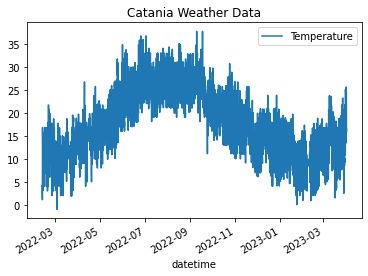

In [5]:
df_new['temp'].plot(label='Temperature', title='Catania Weather Data', legend=True)

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
datetime,,,,,,,,,,,,,,,,,,,,,
2022-02-11 00:00:00,4.200,1.800,2.200,86.730,0.0,0.0,0.0,0.0,13.700,9.700,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:15:00,4.200,1.800,2.200,86.730,0.0,0.0,0.0,0.0,11.350,9.675,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:30:00,4.200,1.800,2.200,86.730,0.0,0.0,0.0,0.0,9.000,9.650,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:45:00,4.200,1.800,2.200,86.730,0.0,0.0,0.0,0.0,6.650,9.625,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:00:00,4.200,1.800,2.200,86.730,0.0,0.0,0.0,0.0,4.300,9.600,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:15:00,4.175,1.700,2.175,86.835,0.0,0.0,0.0,0.0,6.550,9.950,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:30:00,4.150,1.600,2.150,86.940,0.0,0.0,0.0,0.0,8.800,10.300,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:45:00,4.125,1.500,2.125,87.045,0.0,0.0,0.0,0.0,11.050,10.650,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 02:00:00,4.100,1.400,2.100,87.150,0.0,0.0,0.0,0.0,13.300,11.000,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


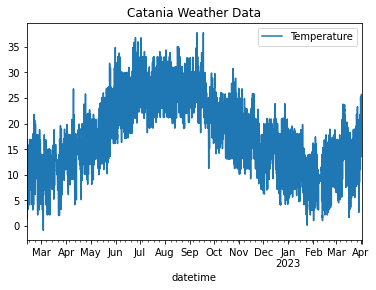

In [6]:
df_weather = df_new

#resample the data to 15 minute intervals
df_weather = df_weather.resample('15T').mean()
df_weather.interpolate(method='linear', inplace=True)
df_weather['temp'].plot(label='Temperature', title='Catania Weather Data', legend=True)
df_weather.head(10)

In [7]:
df_weather.index

DatetimeIndex(['2022-02-11 00:00:00', '2022-02-11 00:15:00',
               '2022-02-11 00:30:00', '2022-02-11 00:45:00',
               '2022-02-11 01:00:00', '2022-02-11 01:15:00',
               '2022-02-11 01:30:00', '2022-02-11 01:45:00',
               '2022-02-11 02:00:00', '2022-02-11 02:15:00',
               ...
               '2023-04-01 20:45:00', '2023-04-01 21:00:00',
               '2023-04-01 21:15:00', '2023-04-01 21:30:00',
               '2023-04-01 21:45:00', '2023-04-01 22:00:00',
               '2023-04-01 22:15:00', '2023-04-01 22:30:00',
               '2023-04-01 22:45:00', '2023-04-01 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=39837, freq='15T')

<AxesSubplot:title={'center':'patients arrived in last timestep'}, xlabel='data_ora_sistema'>

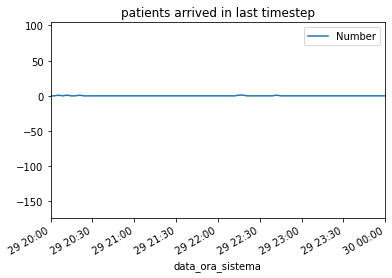

In [8]:
prediction_length = 96  # 48*15min = 12 hours

#now load PS data, clean it
df_ps = pd.read_csv('/Users/aa/Desktop/Astir/data/SmartEUS-PS-100.csv', index_col = 'data_ora_sistema', parse_dates=True)
df_ps = df_ps[15000:] #get rid of first 15000 rows which are spurious
df_ps.drop(['nome', 'pronto_soccorso', 'classe_risorsa', 'data_ora_creazione', 'denominazione_so', 'codice_ps'], axis=1, inplace=True)

#Choose response variable: how many patients arrived in the last time step?
y = pd.DataFrame(df_ps['num_pazienti_giorno_totale_colori'])
#wrangle a bit: need to calculate how many patients arrived in the last time step, so subtract previous row from current row
y = y.diff()
#rename column to 'patients_arrived'
y.rename(columns={'num_pazienti_giorno_totale_colori': 'patients_arrived'}, inplace=True)


y = y[prediction_length:] #shifted by prediction_length in order to predict 24 hours ahead

df_ps.drop(['num_pazienti24ore_totale_colori'],axis=1, inplace=True)
df_ps_new = df_ps.iloc[:-prediction_length] #drop last prediction_length rows to match length of response variable data
y = y.set_index(df_ps_new.index) #re-index y to match df_ps_new

df_ps_new.insert(loc = 0, column = 'y', value = y)

#df_ps_new.head()    
#df_ps.shape
#y.head()
#need to understand what negative values mean in y
y['patients_arrived'].plot(label='Number', title='patients arrived in last timestep', legend=True, xlim = ['2022-08-29 20:00:00', '2022-08-30 00:00:00'])

In [9]:
print (len(y[y['patients_arrived'] < 0])) #check for negative values in y

614


<AxesSubplot:title={'center':'patients arrived in last timestep'}, xlabel='data_ora_sistema'>

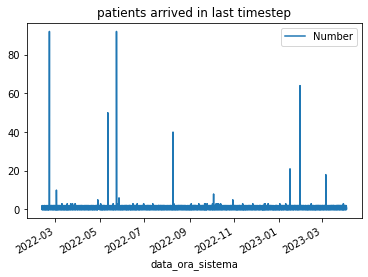

In [10]:
#make negative values zero: they derive from midnight resetting the variable
y[y < 0] = 0
y['patients_arrived'].plot(label='Number', title='patients arrived in last timestep', legend=True)
#now we see spikes at bad events, and the rest of the time rangebound

In [11]:
#resample the PS data to 15 minute intervals, interpolate data to fill in missing values
df_ps = df_ps_new.resample('15T').mean()    

df_ps.interpolate (method='linear', inplace=True)
df_ps.head()

,y,num_pazienti24ore_bianchi,num_pazienti24ore_verdi,num_pazienti24ore_gialli,num_pazienti24ore_rossi,num_pazienti_giorno_totale_colori,num_pazienti_giorno_bianchi,num_pazienti_giorno_verdi,num_pazienti_giorno_gialli,num_pazienti_giorno_rossi,...,tempo_medio_trattamento_bianchi,tempo_medio_trattamento_verdi,tempo_medio_trattamento_gialli,tempo_medio_trattamento_rossi,tempo_medio_permanenza_totale_colori,tempo_medio_permanenza_totale_bianchi,tempo_medio_permanenza_totale_verdi,tempo_medio_permanenza_totale_gialli,tempo_medio_permanenza_totale_rossi,tempo_door_to_bed_ultimo_paziente
data_ora_sistema,,,,,,,,,,,,,,,,,,,,,
2022-02-11 00:00:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,167.00,402.0,658.0,346.00,0.0,290.0,570.0,665.0,395.0
2022-02-11 00:15:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,167.00,402.0,658.0,346.00,0.0,290.0,570.0,665.0,395.0
2022-02-11 00:30:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,166.00,402.0,658.0,345.00,0.0,289.0,570.0,665.0,395.0
2022-02-11 00:45:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,166.00,404.0,658.0,346.00,0.0,289.0,571.0,665.0,614.0
2022-02-11 01:00:00,0.0,0.0,72.0,34.75,5.0,1.75,0.0,0.0,1.75,0.0,...,0.0,165.25,404.0,658.0,345.25,0.0,289.0,571.0,665.0,614.0


In [12]:
#join the PS data with the weather data
df = pd.concat([df_ps, df_weather], join = "inner", axis=1)
df.head()

,y,num_pazienti24ore_bianchi,num_pazienti24ore_verdi,num_pazienti24ore_gialli,num_pazienti24ore_rossi,num_pazienti_giorno_totale_colori,num_pazienti_giorno_bianchi,num_pazienti_giorno_verdi,num_pazienti_giorno_gialli,num_pazienti_giorno_rossi,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
2022-02-11 00:00:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:15:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:30:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 00:45:00,0.0,0.0,72.0,34.00,5.0,1.00,0.0,0.0,1.00,0.0,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11 01:00:00,0.0,0.0,72.0,34.75,5.0,1.75,0.0,0.0,1.75,0.0,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# make variable x = all columns of df except first column  
X = df.iloc[:, 1:] #everything except first column
y = df.iloc[:, 0:1] #select response variable

y.head()
X.shape

(39837, 74)

In [14]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

#first 30000 for training

X_train = X_ss[:35000, :]
X_test = X_ss[35000:, :]

y_train = y_mm[:35000, :]
y_test = y_mm[35000:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (35000, 74) (35000, 1)
Testing Shape (4837, 74) (4837, 1)


In [15]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([35000, 1, 74]) torch.Size([35000, 1])
Testing Shape torch.Size([4837, 1, 74]) torch.Size([4837, 1])


In [16]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [17]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 74 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [18]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 0.01117
Epoch: 100, loss: 0.00023
Epoch: 200, loss: 0.00021
Epoch: 300, loss: 0.00020
Epoch: 400, loss: 0.00019
Epoch: 500, loss: 0.00018
Epoch: 600, loss: 0.00018
Epoch: 700, loss: 0.00017
Epoch: 800, loss: 0.00017
Epoch: 900, loss: 0.00016


In [19]:
df_X_ss = ss.transform(df.iloc[:, 1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 0:1]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

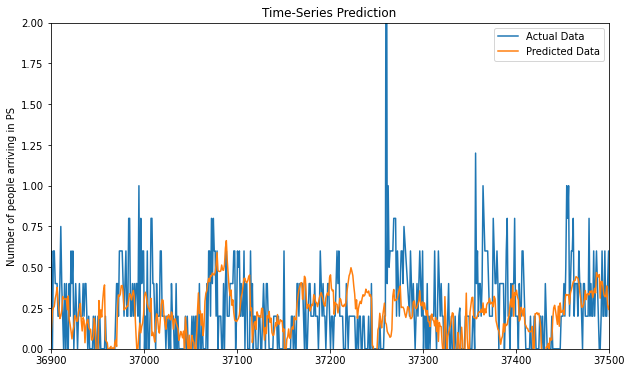

In [20]:


train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=35000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.ylabel('Number of people arriving in PS')
plt.legend()


ax = plt.gca()
xmin = 36900  
xmax = 37500
ymin = 0
ymax = 2
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 

In [21]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#smooth using moving average
averaged_Y = moving_average(dataY_plot, 5)
averaged_pred = moving_average(data_predict, 5) 


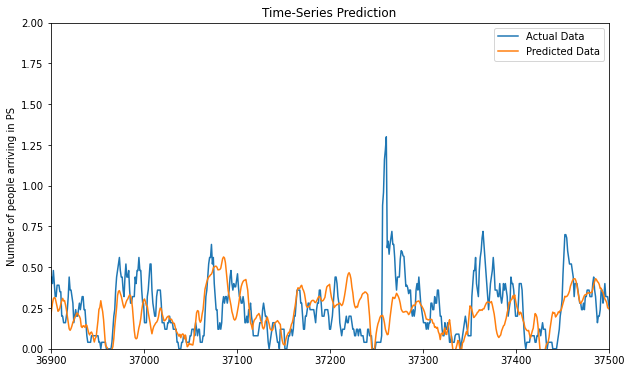

In [22]:

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=35000, c='r', linestyle='--') #size of the training set

plt.plot(averaged_Y, label='Actual Data') #actual plot
plt.plot(averaged_pred, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.ylabel('Number of people arriving in PS')
plt.legend()


ax = plt.gca()
xmin = 36900  
xmax = 37500
ymin = 0
ymax = 2
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 

In [104]:
df.to_csv('df PS and weather.csv', index=True)